In [1]:
# # from google.colab import drive
# drive.mount('/content/drive')

In [2]:
# from google.colab import drive
# drive.mount('/content/drive')
!pwd

/kaggle/working


In [3]:

path = '/kaggle/working/run_1'

In [4]:
!pip install sparsemax

In [5]:
import torch.nn as nn
import torch.nn.functional as F
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
from matplotlib import pyplot as plt
import copy
from sparsemax import Sparsemax

# Ignore warnings
import warnings
warnings.filterwarnings("ignore")
n_seed = 0
#k = 0

In [6]:
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark= False

In [7]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)


testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)


0it [00:00, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [8]:
trainloader = torch.utils.data.DataLoader(trainset, batch_size=10, shuffle=False)
testloader = torch.utils.data.DataLoader(testset, batch_size=10, shuffle=False)


classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

foreground_classes = {'plane', 'car', 'bird'}
#foreground_classes = {'bird', 'cat', 'deer'}
background_classes = {'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck'}
#background_classes = {'plane', 'car', 'dog', 'frog', 'horse','ship', 'truck'}

fg1,fg2,fg3 = 0,1,2

In [9]:
dataiter = iter(trainloader)
background_data=[]
background_label=[]
foreground_data=[]
foreground_label=[]
batch_size=10

for i in range(5000):
  images, labels = dataiter.next()
  for j in range(batch_size):
    if(classes[labels[j]] in background_classes):
      img = images[j].tolist()
      background_data.append(img)
      background_label.append(labels[j])
    else:
      img = images[j].tolist()
      foreground_data.append(img)
      foreground_label.append(labels[j])
            
foreground_data = torch.tensor(foreground_data)
foreground_label = torch.tensor(foreground_label)
background_data = torch.tensor(background_data)
background_label = torch.tensor(background_label)

In [10]:
def create_mosaic_img(bg_idx,fg_idx,fg): 
  """
  bg_idx : list of indexes of background_data[] to be used as background images in mosaic
  fg_idx : index of image to be used as foreground image from foreground data
  fg : at what position/index foreground image has to be stored out of 0-8
  """
  image_list=[]
  j=0
  for i in range(9):
    if i != fg:
      image_list.append(background_data[bg_idx[j]])#.type("torch.DoubleTensor"))
      j+=1
    else: 
      image_list.append(foreground_data[fg_idx])#.type("torch.DoubleTensor"))
      label = foreground_label[fg_idx]- fg1  # minus fg1 because our fore ground classes are fg1,fg2,fg3 but we have to store it as 0,1,2
  #image_list = np.concatenate(image_list ,axis=0)
  image_list = torch.stack(image_list) 
  return image_list,label

In [11]:
desired_num = 30000
mosaic_list_of_images =[]      # list of mosaic images, each mosaic image is saved as list of 9 images
fore_idx =[]                   # list of indexes at which foreground image is present in a mosaic image i.e from 0 to 9               
mosaic_label=[]                # label of mosaic image = foreground class present in that mosaic
for i in range(desired_num):
  np.random.seed(i)
  bg_idx = np.random.randint(0,35000,8)
  fg_idx = np.random.randint(0,15000)
  fg = np.random.randint(0,9)
  fore_idx.append(fg)
  image_list,label = create_mosaic_img(bg_idx,fg_idx,fg)
  mosaic_list_of_images.append(image_list)
  mosaic_label.append(label)

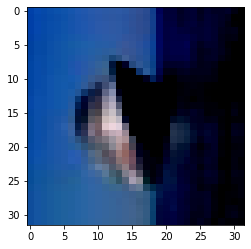

In [12]:
plt.imshow(torch.transpose(mosaic_list_of_images[0][1],dim0= 0,dim1 = 2))

In [13]:
class MosaicDataset(Dataset):
  """MosaicDataset dataset."""

  def __init__(self, mosaic_list_of_images, mosaic_label, fore_idx):
    """
      Args:
        csv_file (string): Path to the csv file with annotations.
        root_dir (string): Directory with all the images.
        transform (callable, optional): Optional transform to be applied
            on a sample.
    """
    self.mosaic = mosaic_list_of_images
    self.label = mosaic_label
    self.fore_idx = fore_idx

  def __len__(self):
    return len(self.label)

  def __getitem__(self, idx):
    return self.mosaic[idx] , self.label[idx], self.fore_idx[idx]

batch = 250
msd = MosaicDataset(mosaic_list_of_images, mosaic_label , fore_idx)
train_loader = DataLoader( msd,batch_size= batch ,shuffle=True)

In [14]:
class Focus(nn.Module):
  def __init__(self):
    super(Focus, self).__init__()
    self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=0,bias=False)
    self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=0,bias=False)
    self.conv3 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=0,bias=False)
    self.conv4 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=0,bias=False)
    self.conv5 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=0,bias=False)
    self.conv6 = nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1,bias=False)
    self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
    self.batch_norm1 = nn.BatchNorm2d(32,track_running_stats=False)
    self.batch_norm2 = nn.BatchNorm2d(64,track_running_stats=False)
    self.batch_norm3 = nn.BatchNorm2d(256,track_running_stats=False)
    self.dropout1 = nn.Dropout2d(p=0.05)
    self.dropout2 = nn.Dropout2d(p=0.1)
    self.fc1 = nn.Linear(256,64,bias=False)
    self.fc2 = nn.Linear(64, 32,bias=False)
    self.fc3 = nn.Linear(32, 10,bias=False)
    self.fc4 = nn.Linear(10, 1,bias=False)
    
    torch.nn.init.xavier_normal_(self.conv1.weight)
    torch.nn.init.xavier_normal_(self.conv2.weight)
    torch.nn.init.xavier_normal_(self.conv3.weight)
    torch.nn.init.xavier_normal_(self.conv4.weight)
    torch.nn.init.xavier_normal_(self.conv5.weight)
    torch.nn.init.xavier_normal_(self.conv6.weight)

    torch.nn.init.xavier_normal_(self.fc1.weight)
    torch.nn.init.xavier_normal_(self.fc2.weight)
    torch.nn.init.xavier_normal_(self.fc3.weight)
    torch.nn.init.xavier_normal_(self.fc4.weight)
    
    self.sparsemax = Sparsemax(dim=-1) 


  def forward(self,z):  #y is avg image #z batch of list of 9 images
    y = torch.zeros([batch,3, 32,32], dtype=torch.float64)
    x = torch.zeros([batch,9],dtype=torch.float64)
    #ftr = torch.zeros([batch,9,3,32,32])
    y = y.to("cuda")
    x = x.to("cuda")
    #ftr = ftr.to("cuda")
    
    for i in range(9):
        out = self.helper(z[:,i])
        #print(out.shape)
        x[:,i] = out[:,0]
     
    
    x = self.sparsemax(x)

    for i in range(9):            
      x1 = x[:,i]          
      y = y + torch.mul(x1[:,None,None,None],z[:,i])

    return x, y #alpha,avg_data
    
  def helper(self, x):
    #x1 = x
    #x1 =x
    x = self.conv1(x)
    x = F.relu(self.batch_norm1(x))

    x = (F.relu(self.conv2(x)))
    x = self.pool(x)
    
    x = self.conv3(x)
    x = F.relu(self.batch_norm2(x))

    x = (F.relu(self.conv4(x)))
    x = self.pool(x)
    x = self.dropout1(x)

    x = self.conv5(x)
    
    x = F.relu(self.batch_norm3(x))

    x = self.conv6(x)
    
    x = F.relu(x)
    x = self.pool(x)

    x = x.view(x.size(0), -1)

    x = self.dropout2(x)
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    x = self.dropout2(x)
    x = F.relu(self.fc3(x))
    x = self.fc4(x)
    return x

In [15]:
torch.manual_seed(n_seed)
focus_net = Focus().double()
focus_net = focus_net.to("cuda")

In [16]:
class Classification(nn.Module):
  def __init__(self):
    super(Classification, self).__init__()
    self.conv1 = nn.Conv2d(in_channels=3, out_channels=128, kernel_size=3, padding=1)
    self.conv2 = nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1)
    self.conv3 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1)
    self.conv4 = nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1)
    self.conv5 = nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, padding=1)
    self.conv6 = nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1)
    self.pool = nn.MaxPool2d(kernel_size=2, stride=2,padding=1)
    self.batch_norm1 = nn.BatchNorm2d(128,track_running_stats=False)
    self.batch_norm2 = nn.BatchNorm2d(256,track_running_stats=False)
    self.batch_norm3 = nn.BatchNorm2d(512,track_running_stats=False)
    self.dropout1 = nn.Dropout2d(p=0.05)
    self.dropout2 = nn.Dropout2d(p=0.1)
    self.global_average_pooling = nn.AvgPool2d(kernel_size=4)
    self.fc1 = nn.Linear(512,128)
    # self.fc2 = nn.Linear(128, 64)
    # self.fc3 = nn.Linear(64, 10)
    self.fc2 = nn.Linear(128, 3)


    torch.nn.init.xavier_normal_(self.conv1.weight)
    torch.nn.init.xavier_normal_(self.conv2.weight)
    torch.nn.init.xavier_normal_(self.conv3.weight)
    torch.nn.init.xavier_normal_(self.conv4.weight)
    torch.nn.init.xavier_normal_(self.conv5.weight)
    torch.nn.init.xavier_normal_(self.conv6.weight)

    torch.nn.init.zeros_(self.conv1.bias)
    torch.nn.init.zeros_(self.conv2.bias)
    torch.nn.init.zeros_(self.conv3.bias)
    torch.nn.init.zeros_(self.conv4.bias)
    torch.nn.init.zeros_(self.conv5.bias)
    torch.nn.init.zeros_(self.conv6.bias)


    torch.nn.init.xavier_normal_(self.fc1.weight)
    torch.nn.init.xavier_normal_(self.fc2.weight)
    torch.nn.init.zeros_(self.fc1.bias)
    torch.nn.init.zeros_(self.fc2.bias)


  def forward(self, x):
    x = self.conv1(x)
    x = F.relu(self.batch_norm1(x))

    x = (F.relu(self.conv2(x)))
    x = self.pool(x)
    
    x = self.conv3(x)
    x = F.relu(self.batch_norm2(x))

    x = (F.relu(self.conv4(x)))
    x = self.pool(x)
    x = self.dropout1(x)

    x = self.conv5(x)
    x = F.relu(self.batch_norm3(x))

    x = (F.relu(self.conv6(x)))
    x = self.pool(x)
    #print(x.shape)
    x = self.global_average_pooling(x)
    x = x.squeeze()
    #x = x.view(x.size(0), -1)
    #print(x.shape)
    x = self.dropout2(x)
    x = F.relu(self.fc1(x))
    #x = F.relu(self.fc2(x))
    #x = self.dropout2(x)
    #x = F.relu(self.fc3(x))
    x = self.fc2(x)
    return x

In [17]:
torch.manual_seed(n_seed)
classify = Classification().double()
classify = classify.to("cuda")

In [18]:
test_images =[]        #list of mosaic images, each mosaic image is saved as laist of 9 images
fore_idx_test =[]                   #list of indexes at which foreground image is present in a mosaic image                
test_label=[]                # label of mosaic image = foreground class present in that mosaic
for i in range(10000):
  np.random.seed(i+30000)
  bg_idx = np.random.randint(0,35000,8)
  fg_idx = np.random.randint(0,15000)
  fg = np.random.randint(0,9)
  fore_idx_test.append(fg)
  image_list,label = create_mosaic_img(bg_idx,fg_idx,fg)
  test_images.append(image_list)
  test_label.append(label)

In [19]:
test_data = MosaicDataset(test_images,test_label,fore_idx_test)
test_loader = DataLoader( test_data,batch_size= batch ,shuffle=False)

In [20]:
criterion = nn.CrossEntropyLoss()

In [21]:
import torch.optim as optim
# criterion_classify = nn.CrossEntropyLoss()
optimizer_focus = optim.Adam(focus_net.parameters(), lr=0.003)#, momentum=0.9)
optimizer_classify = optim.Adam(classify.parameters(), lr=0.003)#, momentum=0.9)

In [22]:
col1=[]
col2=[]
col3=[]
col4=[]
col5=[]
col6=[]
col7=[]
col8=[]
col9=[]
col10=[]
col11=[]
col12=[]
col13=[]
col14 = [] # train average sparsity
col15 = [] # test average sparsity



In [23]:
correct = 0
total = 0
count = 0
flag = 1
focus_true_pred_true =0
focus_false_pred_true =0
focus_true_pred_false =0
focus_false_pred_false =0

argmax_more_than_half = 0
argmax_less_than_half =0
sparse_val = 0 
focus_net.eval()
classify.eval()
with torch.no_grad():
  for data in train_loader:
    inputs, labels , fore_idx = data
    inputs = inputs.double()
    inputs, labels , fore_idx = inputs.to("cuda"),labels.to("cuda"), fore_idx.to("cuda")
    alphas, avg_images = focus_net(inputs)
    outputs = classify(avg_images)

    _, predicted = torch.max(outputs.data, 1)
    
    sparse_val += torch.sum(torch.sum(alphas>0.01,dim=1)).item()


    for j in range(labels.size(0)):
      count += 1
      focus = torch.argmax(alphas[j])
      if alphas[j][focus] >= 0.5 :
        argmax_more_than_half += 1
      else:
        argmax_less_than_half += 1

      if(focus == fore_idx[j] and predicted[j] == labels[j]):
          focus_true_pred_true += 1
      elif(focus != fore_idx[j] and predicted[j] == labels[j]):
        focus_false_pred_true += 1
      elif(focus == fore_idx[j] and predicted[j] != labels[j]):
        focus_true_pred_false += 1
      elif(focus != fore_idx[j] and predicted[j] != labels[j]):
        focus_false_pred_false += 1

    total += labels.size(0)
    correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 30000 train images: %f %%' % ( 100 * correct / total))
print("total correct", correct)
print("total train set images", total)

print("focus_true_pred_true %d =============> FTPT : %f %%" % (focus_true_pred_true , (100 * focus_true_pred_true / total) ) )
print("focus_false_pred_true %d =============> FFPT : %f %%" % (focus_false_pred_true, (100 * focus_false_pred_true / total) ) )
print("focus_true_pred_false %d =============> FTPF : %f %%" %( focus_true_pred_false , ( 100 * focus_true_pred_false / total) ) )
print("focus_false_pred_false %d =============> FFPF : %f %%" % (focus_false_pred_false, ( 100 * focus_false_pred_false / total) ) )
print("Sparsity_Value %d =============> AVG Sparsity : %f " % (sparse_val,(sparse_val)/total))
print("argmax_more_than_half ==================> ",argmax_more_than_half)
print("argmax_less_than_half ==================> ",argmax_less_than_half)
print(count)

print("="*100)

col1.append(0)
col2.append(argmax_more_than_half)
col3.append(argmax_less_than_half)
col4.append(focus_true_pred_true)
col5.append(focus_false_pred_true)
col6.append(focus_true_pred_false)
col7.append(focus_false_pred_false)
col14.append(sparse_val)

Accuracy of the network on the 30000 train images: 33.723333 %
total correct 10117
total train set images 30000
focus_true_pred_true 400 =============> FTPT : 1.333333 %
focus_false_pred_true 9717 =============> FFPT : 32.390000 %
focus_true_pred_false 1606 =============> FTPF : 5.353333 %
focus_false_pred_false 18277 =============> FFPF : 60.923333 %
Sparsity_Value 165004 =============> AVG Sparsity : 5.500133 
argmax_more_than_half ==================>  934
argmax_less_than_half ==================>  29066
30000


In [24]:
correct = 0
total = 0
count = 0
flag = 1
focus_true_pred_true =0
focus_false_pred_true =0
focus_true_pred_false =0
focus_false_pred_false =0

argmax_more_than_half = 0
argmax_less_than_half =0
sparse_val = 0
focus_net.eval()
classify.eval()
with torch.no_grad():
  for data in test_loader:
    inputs, labels , fore_idx = data
    inputs = inputs.double()
    inputs, labels , fore_idx = inputs.to("cuda"),labels.to("cuda"), fore_idx.to("cuda")
    alphas, avg_images = focus_net(inputs)
    outputs = classify(avg_images)

    _, predicted = torch.max(outputs.data, 1)
    
    sparse_val += torch.sum(torch.sum(alphas>0.01,dim=1)).item()

    for j in range(labels.size(0)):
      focus = torch.argmax(alphas[j])
      if alphas[j][focus] >= 0.5 :
        argmax_more_than_half += 1
      else:
        argmax_less_than_half += 1

      if(focus == fore_idx[j] and predicted[j] == labels[j]):
          focus_true_pred_true += 1
      elif(focus != fore_idx[j] and predicted[j] == labels[j]):
        focus_false_pred_true += 1
      elif(focus == fore_idx[j] and predicted[j] != labels[j]):
        focus_true_pred_false += 1
      elif(focus != fore_idx[j] and predicted[j] != labels[j]):
        focus_false_pred_false += 1

    total += labels.size(0)
    correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %f %%' % (
    100 * correct / total))
print("total correct", correct)
print("total test set images", total)

print("focus_true_pred_true %d =============> FTPT : %f %%" % (focus_true_pred_true , (100 * focus_true_pred_true / total) ) )
print("focus_false_pred_true %d =============> FFPT : %f %%" % (focus_false_pred_true, (100 * focus_false_pred_true / total) ) )
print("focus_true_pred_false %d =============> FTPF : %f %%" %( focus_true_pred_false , ( 100 * focus_true_pred_false / total) ) )
print("focus_false_pred_false %d =============> FFPF : %f %%" % (focus_false_pred_false, ( 100 * focus_false_pred_false / total) ) )
print("Sparsity_Value %d =============> AVG Sparsity : %f " % (sparse_val,(sparse_val)/total))
print("argmax_more_than_half ==================> ",argmax_more_than_half)
print("argmax_less_than_half ==================> ",argmax_less_than_half)
col8.append(argmax_more_than_half)
col9.append(argmax_less_than_half)
col10.append(focus_true_pred_true)
col11.append(focus_false_pred_true)
col12.append(focus_true_pred_false)
col13.append(focus_false_pred_false)
col15.append(sparse_val)

Accuracy of the network on the 10000 test images: 33.500000 %
total correct 3350
total test set images 10000
focus_true_pred_true 138 =============> FTPT : 1.380000 %
focus_false_pred_true 3212 =============> FFPT : 32.120000 %
focus_true_pred_false 514 =============> FTPF : 5.140000 %
focus_false_pred_false 6136 =============> FFPF : 61.360000 %
Sparsity_Value 55044 =============> AVG Sparsity : 5.504400 
argmax_more_than_half ==================>  298
argmax_less_than_half ==================>  9702


In [25]:
nos_epochs = 50
focus_true_pred_true =0
focus_false_pred_true =0
focus_true_pred_false =0
focus_false_pred_false =0

argmax_more_than_half = 0
argmax_less_than_half =0
focus_net.train()
classify.train()
tr_loss = []


for epoch in range(nos_epochs):  # loop over the dataset multiple times
  focus_net.train()
  classify.train()
  focus_true_pred_true =0
  focus_false_pred_true =0
  focus_true_pred_false =0
  focus_false_pred_false =0
  
  argmax_more_than_half = 0
  argmax_less_than_half =0
  sparse_val = 0 
  
  running_loss = 0.0
  epoch_loss = []
  cnt=0

  iteration = desired_num // batch
  
  #training data set
  
  for i, data in  enumerate(train_loader):
    inputs , labels , fore_idx = data
    inputs = inputs.double()
    inputs, labels = inputs.to("cuda"), labels.to("cuda")
    # zero the parameter gradients
    optimizer_focus.zero_grad()
    optimizer_classify.zero_grad()
    alphas, avg_images = focus_net(inputs)
    outputs = classify(avg_images)
    
    # outputs, alphas, avg_images = classify(inputs)

    _, predicted = torch.max(outputs.data, 1)
#     print(outputs)
#     print(outputs.shape,labels.shape , torch.argmax(outputs, dim=1))

    loss = criterion(outputs, labels)
    loss.backward()
    optimizer_focus.step()
    optimizer_classify.step()

    running_loss += loss.item()
    mini = 60
    if cnt % mini == mini-1:    # print every 40 mini-batches
      print('[%d, %5d] loss: %.3f' %(epoch + 1, cnt + 1, running_loss / mini))
      epoch_loss.append(running_loss/mini)
      running_loss = 0.0
    cnt=cnt+1
    
    
    if epoch % 1 == 0:
      sparse_val += torch.sum(torch.sum(alphas>0.01,dim=1)).item()
      for j in range (batch):
        focus = torch.argmax(alphas[j])

        if(alphas[j][focus] >= 0.5):
          argmax_more_than_half +=1
        else:
          argmax_less_than_half +=1

        if(focus == fore_idx[j] and predicted[j] == labels[j]):
          focus_true_pred_true += 1

        elif(focus != fore_idx[j] and predicted[j] == labels[j]):
          focus_false_pred_true +=1

        elif(focus == fore_idx[j] and predicted[j] != labels[j]):
          focus_true_pred_false +=1

        elif(focus != fore_idx[j] and predicted[j] != labels[j]):
          focus_false_pred_false +=1


  tr_loss.append(np.mean(epoch_loss))
  if epoch % 1 == 0:
    col1.append(epoch+1)
    col2.append(argmax_more_than_half)
    col3.append(argmax_less_than_half)
    col4.append(focus_true_pred_true)
    col5.append(focus_false_pred_true)
    col6.append(focus_true_pred_false)
    col7.append(focus_false_pred_false)
    col14.append(sparse_val)
  
    #************************************************************************
    #testing data set 
    focus_net.eval()
    classify.eval() 
    with torch.no_grad():
      focus_true_pred_true =0
      focus_false_pred_true =0
      focus_true_pred_false =0
      focus_false_pred_false =0

      argmax_more_than_half = 0
      argmax_less_than_half =0
      sparse_val = 0
      for data in test_loader:
        inputs, labels , fore_idx = data
        inputs = inputs.double()
        inputs, labels = inputs.to("cuda"), labels.to("cuda")
        alphas, avg_images  = focus_net(inputs)
        outputs = classify(avg_images)
        #outputs, alphas, avg_images = classify(inputs)
        _, predicted = torch.max(outputs.data, 1)
        sparse_val += torch.sum(torch.sum(alphas>0.01,dim=1)).item()
        for j in range (batch):
          focus = torch.argmax(alphas[j])

          if(alphas[j][focus] >= 0.5):
            argmax_more_than_half +=1
          else:
            argmax_less_than_half +=1

          if(focus == fore_idx[j] and predicted[j] == labels[j]):
            focus_true_pred_true += 1

          elif(focus != fore_idx[j] and predicted[j] == labels[j]):
            focus_false_pred_true +=1

          elif(focus == fore_idx[j] and predicted[j] != labels[j]):
            focus_true_pred_false +=1

          elif(focus != fore_idx[j] and predicted[j] != labels[j]):
            focus_false_pred_false +=1
      
    col8.append(argmax_more_than_half)
    col9.append(argmax_less_than_half)
    col10.append(focus_true_pred_true)
    col11.append(focus_false_pred_true)
    col12.append(focus_true_pred_false)
    col13.append(focus_false_pred_false)
    col15.append(sparse_val)
  if(np.mean(epoch_loss) <= 0.05):
    break;
print('Finished Training') 

[1,    60] loss: 1.937
[1,   120] loss: 1.096
[2,    60] loss: 1.090
[2,   120] loss: 1.094
[3,    60] loss: 1.088
[3,   120] loss: 1.070
[4,    60] loss: 1.067
[4,   120] loss: 1.056
[5,    60] loss: 1.034
[5,   120] loss: 1.037
[6,    60] loss: 1.050
[6,   120] loss: 1.021
[7,    60] loss: 1.014
[7,   120] loss: 1.010
[8,    60] loss: 1.017
[8,   120] loss: 0.998
[9,    60] loss: 1.037
[9,   120] loss: 1.081
[10,    60] loss: 1.077
[10,   120] loss: 1.074
[11,    60] loss: 1.069
[11,   120] loss: 1.063
[12,    60] loss: 1.055
[12,   120] loss: 1.063
[13,    60] loss: 1.048
[13,   120] loss: 1.048
[14,    60] loss: 1.046
[14,   120] loss: 1.050
[15,    60] loss: 1.030
[15,   120] loss: 1.036
[16,    60] loss: 1.028
[16,   120] loss: 1.035
[17,    60] loss: 1.037
[17,   120] loss: 1.035
[18,    60] loss: 1.032
[18,   120] loss: 1.031
[19,    60] loss: 1.027
[19,   120] loss: 1.035
[20,    60] loss: 1.030
[20,   120] loss: 1.029
[21,    60] loss: 1.025
[21,   120] loss: 1.039
[22,    60

In [26]:
torch.save(focus_net.state_dict(),path+"weights_focus_0.pt")  
torch.save(classify.state_dict(),path+"weights_classify_0.pt")

In [27]:
columns = ["epochs", "argmax > 0.5" ,"argmax < 0.5", "focus_true_pred_true", "focus_false_pred_true", "focus_true_pred_false", "focus_false_pred_false" ,"sparse_val"]

In [28]:
df_train = pd.DataFrame()
df_test = pd.DataFrame()

In [29]:
len(col1),col9

(51,
 [9702,
  17,
  4,
  1205,
  0,
  9,
  1,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  1,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0])

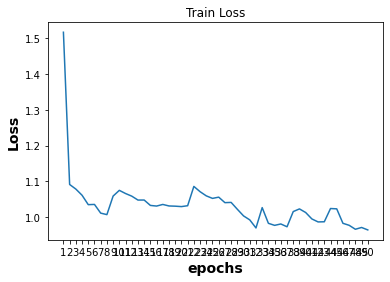

In [30]:
plt.plot(np.arange(1,epoch+2),tr_loss)
plt.xlabel("epochs", fontsize=14, fontweight = 'bold')
plt.ylabel("Loss", fontsize=14, fontweight = 'bold')
plt.xticks(np.arange(1,epoch+2))
plt.title("Train Loss")
#plt.grid()
plt.show()

In [31]:
np.save("train_loss.npy",{"training_loss":tr_loss})

In [32]:
df_train[columns[0]] = col1
df_train[columns[1]] = col2
df_train[columns[2]] = col3
df_train[columns[3]] = col4
df_train[columns[4]] = col5
df_train[columns[5]] = col6
df_train[columns[6]] = col7
df_train[columns[7]] = col14

df_test[columns[0]] = col1
df_test[columns[1]] = col8
df_test[columns[2]] = col9
df_test[columns[3]] = col10
df_test[columns[4]] = col11
df_test[columns[5]] = col12
df_test[columns[6]] = col13
df_test[columns[7]] = col15

In [33]:
df_train

,epochs,argmax > 0.5,argmax < 0.5,focus_true_pred_true,focus_false_pred_true,focus_true_pred_false,focus_false_pred_false,sparse_val
0,0,934,29066,400,9717,1606,18277,165004
1,1,29597,403,2166,8184,2654,16996,38322
2,2,29968,32,2573,8718,1791,16918,34069
3,3,29903,97,3424,8548,1844,16184,34754
4,4,29958,42,4646,8148,2133,15073,32948
5,5,29999,1,5650,8075,2084,14191,30613
6,6,29981,19,5030,8234,1607,15129,30751
7,7,29999,1,5570,8453,1597,14380,30224
8,8,29999,1,5416,8479,1561,14544,30171
9,9,30000,0,3506,8741,1100,16653,30128


In [34]:
df_train.to_csv(path+"_train.csv",index=False)

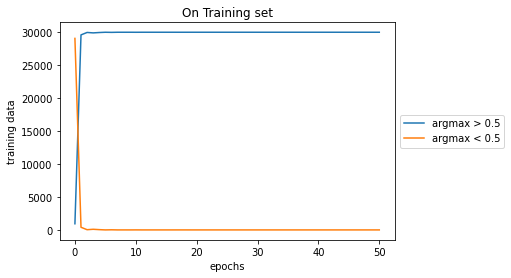

In [35]:
# plt.figure(12,12)
plt.plot(col1,col2, label='argmax > 0.5')
plt.plot(col1,col3, label='argmax < 0.5')

plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.xlabel("epochs")
plt.ylabel("training data")
plt.title("On Training set")
plt.show()



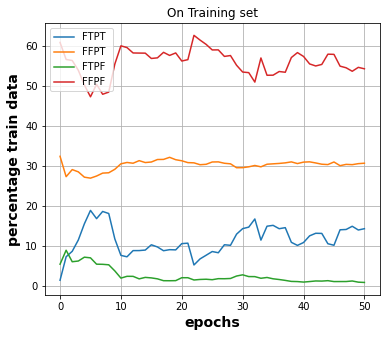

In [36]:
plt.figure(figsize=(6,5))
plt.plot(col1,np.array(col4)/300, label ="FTPT ")
plt.plot(col1,np.array(col5)/300, label ="FFPT ")
plt.plot(col1,np.array(col6)/300, label ="FTPF ")
plt.plot(col1,np.array(col7)/300, label ="FFPF ")
plt.title("On Training set")
#plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.xlabel("epochs", fontsize=14, fontweight = 'bold')
plt.ylabel("percentage train data", fontsize=14, fontweight = 'bold')
# plt.xlabel("epochs")
# plt.ylabel("training data")
plt.legend()

plt.savefig(path + "_train.png",bbox_inches="tight")
plt.savefig(path + "_train.pdf",bbox_inches="tight")
plt.grid()
plt.show()

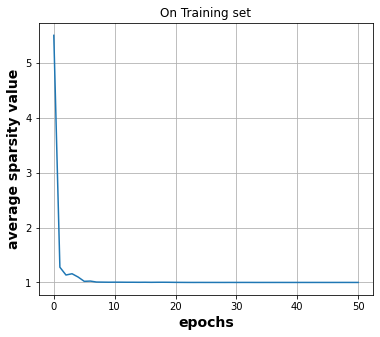

In [37]:
plt.figure(figsize=(6,5))
plt.plot(col1,np.array(col14)/30000, label ="sparsity_val")

plt.title("On Training set")
#plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.xlabel("epochs", fontsize=14, fontweight = 'bold')
plt.ylabel("average sparsity value", fontsize=14, fontweight = 'bold')
# plt.xlabel("epochs")
# plt.ylabel("sparsity_value")

plt.savefig(path + "sparsity_train.png",bbox_inches="tight")
plt.savefig(path + "sparsity_train.pdf",bbox_inches="tight")
plt.grid()
plt.show()

In [38]:
df_test

,epochs,argmax > 0.5,argmax < 0.5,focus_true_pred_true,focus_false_pred_true,focus_true_pred_false,focus_false_pred_false,sparse_val
0,0,298,9702,138,3212,514,6136,55044
1,1,9983,17,892,2858,643,5607,11604
2,2,9996,4,844,2960,532,5664,11133
3,3,8795,1205,1110,2901,722,5267,20983
4,4,10000,0,1943,2554,792,4711,10268
5,5,9991,9,1861,2750,757,4632,10354
6,6,9999,1,1635,2778,501,5086,10063
7,7,10000,0,1619,2810,526,5045,10058
8,8,10000,0,1236,2928,479,5357,10048
9,9,10000,0,713,3097,178,6012,10050


In [39]:
df_test.to_csv(path+"_test.csv")

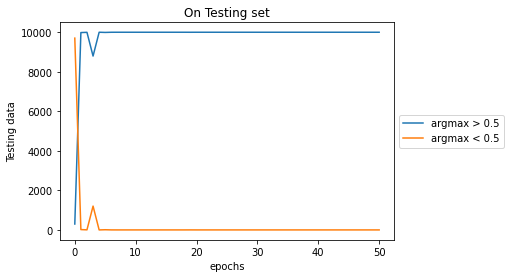

In [40]:
# plt.figure(12,12)
plt.plot(col1,col8, label='argmax > 0.5')
plt.plot(col1,col9, label='argmax < 0.5')

plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.xlabel("epochs")
plt.ylabel("Testing data")
plt.title("On Testing set")
plt.show()



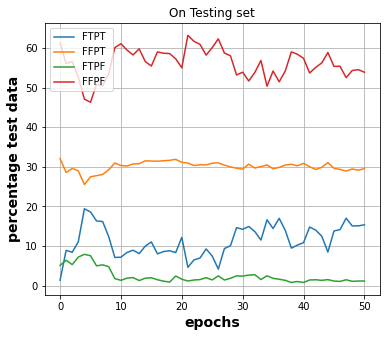

In [41]:
plt.figure(figsize=(6,5))
plt.plot(col1,np.array(col10)/100, label ="FTPT ")
plt.plot(col1,np.array(col11)/100, label ="FFPT ")
plt.plot(col1,np.array(col12)/100, label ="FTPF ")
plt.plot(col1,np.array(col13)/100, label ="FFPF ")
plt.title("On Testing set")

#plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.xlabel("epochs", fontsize=14, fontweight = 'bold')
plt.ylabel("percentage test data", fontsize=14, fontweight = 'bold')
# plt.xlabel("epochs")
# plt.ylabel("training data")
plt.legend()

#plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.xlabel("epochs")
# plt.ylabel("Testing data")
plt.savefig(path + "_test.png",bbox_inches="tight")
plt.savefig(path + "_test.pdf",bbox_inches="tight")
plt.grid()
plt.show()

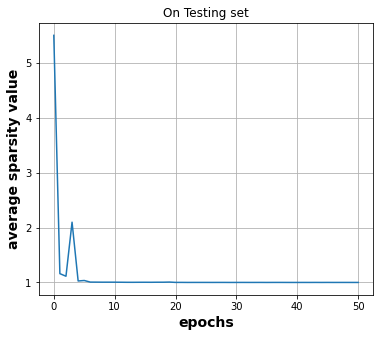

In [42]:
plt.figure(figsize=(6,5))
plt.plot(col1,np.array(col15)/10000, label ="sparsity_val")

plt.title("On Testing set")
#plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.xlabel("epochs", fontsize=14, fontweight = 'bold')
plt.ylabel("average sparsity value", fontsize=14, fontweight = 'bold')
plt.grid()

plt.savefig(path + "sparsity_test.png",bbox_inches="tight")
plt.savefig(path + "sparsity_test.pdf",bbox_inches="tight")
plt.show()

In [43]:
correct = 0
total = 0
count = 0
flag = 1
focus_true_pred_true =0
focus_false_pred_true =0
focus_true_pred_false =0
focus_false_pred_false =0

argmax_more_than_half = 0
argmax_less_than_half =0
sparse_val = 0
focus_net.eval()
classify.eval()
with torch.no_grad():
  for data in train_loader:
    inputs, labels , fore_idx = data
    inputs = inputs.double()
    inputs, labels , fore_idx = inputs.to("cuda"),labels.to("cuda"), fore_idx.to("cuda")
    alphas, avg_images = focus_net(inputs)
    outputs = classify(avg_images)

    _, predicted = torch.max(outputs.data, 1)
    sparse_val += torch.sum(torch.sum(alphas>0.01,dim=1)).item()
    for j in range(labels.size(0)):
      count += 1
      focus = torch.argmax(alphas[j])
      if alphas[j][focus] >= 0.5 :
        argmax_more_than_half += 1
      else:
        argmax_less_than_half += 1

      if(focus == fore_idx[j] and predicted[j] == labels[j]):
          focus_true_pred_true += 1
      elif(focus != fore_idx[j] and predicted[j] == labels[j]):
        focus_false_pred_true += 1
      elif(focus == fore_idx[j] and predicted[j] != labels[j]):
        focus_true_pred_false += 1
      elif(focus != fore_idx[j] and predicted[j] != labels[j]):
        focus_false_pred_false += 1

    total += labels.size(0)
    correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 30000 train images: %f %%' % ( 100 * correct / total))
print("total correct", correct)
print("total train set images", total)

print("focus_true_pred_true %d =============> FTPT : %f %%" % (focus_true_pred_true , (100 * focus_true_pred_true / total) ) )
print("focus_false_pred_true %d =============> FFPT : %f %%" % (focus_false_pred_true, (100 * focus_false_pred_true / total) ) )
print("focus_true_pred_false %d =============> FTPF : %f %%" %( focus_true_pred_false , ( 100 * focus_true_pred_false / total) ) )
print("focus_false_pred_false %d =============> FFPF : %f %%" % (focus_false_pred_false, ( 100 * focus_false_pred_false / total) ) )
print("Sparsity_Value %d =============> AVG Sparsity : %f " % (sparse_val,(sparse_val)/total))
print("argmax_more_than_half ==================> ",argmax_more_than_half)
print("argmax_less_than_half ==================> ",argmax_less_than_half)
print(count)

print("="*100)

Accuracy of the network on the 30000 train images: 46.386667 %
total correct 13916
total train set images 30000
focus_true_pred_true 4409 =============> FTPT : 14.696667 %
focus_false_pred_true 9507 =============> FFPT : 31.690000 %
focus_true_pred_false 166 =============> FTPF : 0.553333 %
focus_false_pred_false 15918 =============> FFPF : 53.060000 %
Sparsity_Value 30009 =============> AVG Sparsity : 1.000300 
argmax_more_than_half ==================>  30000
argmax_less_than_half ==================>  0
30000


In [44]:
correct = 0
total = 0
count = 0
flag = 1
focus_true_pred_true =0
focus_false_pred_true =0
focus_true_pred_false =0
focus_false_pred_false =0

argmax_more_than_half = 0
argmax_less_than_half =0
sparse_val = 0 
focus_net.eval()
classify.eval()
with torch.no_grad():
  for data in test_loader:
    inputs, labels , fore_idx = data
    inputs = inputs.double()
    inputs, labels , fore_idx = inputs.to("cuda"),labels.to("cuda"), fore_idx.to("cuda")
    alphas, avg_images  = focus_net(inputs)
    outputs = classify(avg_images)

    _, predicted = torch.max(outputs.data, 1)
    sparse_val += torch.sum(torch.sum(alphas>0.01,dim=1)).item()
    for j in range(labels.size(0)):
      focus = torch.argmax(alphas[j])
      if alphas[j][focus] >= 0.5 :
        argmax_more_than_half += 1
      else:
        argmax_less_than_half += 1

      if(focus == fore_idx[j] and predicted[j] == labels[j]):
          focus_true_pred_true += 1
      elif(focus != fore_idx[j] and predicted[j] == labels[j]):
        focus_false_pred_true += 1
      elif(focus == fore_idx[j] and predicted[j] != labels[j]):
        focus_true_pred_false += 1
      elif(focus != fore_idx[j] and predicted[j] != labels[j]):
        focus_false_pred_false += 1

    total += labels.size(0)
    correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %f %%' % (
    100 * correct / total))
print("total correct", correct)
print("total test set images", total)

print("focus_true_pred_true %d =============> FTPT : %f %%" % (focus_true_pred_true , (100 * focus_true_pred_true / total) ) )
print("focus_false_pred_true %d =============> FFPT : %f %%" % (focus_false_pred_true, (100 * focus_false_pred_true / total) ) )
print("focus_true_pred_false %d =============> FTPF : %f %%" %( focus_true_pred_false , ( 100 * focus_true_pred_false / total) ) )
print("focus_false_pred_false %d =============> FFPF : %f %%" % (focus_false_pred_false, ( 100 * focus_false_pred_false / total) ) )
print("Sparsity_Value %d =============> AVG Sparsity : %f " % (sparse_val,(sparse_val)/total))

print("argmax_more_than_half ==================> ",argmax_more_than_half)
print("argmax_less_than_half ==================> ",argmax_less_than_half)

Accuracy of the network on the 10000 test images: 44.920000 %
total correct 4492
total test set images 10000
focus_true_pred_true 1537 =============> FTPT : 15.370000 %
focus_false_pred_true 2955 =============> FFPT : 29.550000 %
focus_true_pred_false 118 =============> FTPF : 1.180000 %
focus_false_pred_false 5390 =============> FFPF : 53.900000 %
Sparsity_Value 10001 =============> AVG Sparsity : 1.000100 
argmax_more_than_half ==================>  10000
argmax_less_than_half ==================>  0


In [45]:
correct = 0
total = 0
focus_net.eval()
classify.eval()
with torch.no_grad():
  for data in train_loader:
    inputs, labels , fore_idx = data
    inputs = inputs.double()
    inputs, labels = inputs.to("cuda"), labels.to("cuda")
    alphas, avg_images = focus_net(inputs)
    outputs = classify(avg_images)

    _, predicted = torch.max(outputs.data, 1)

    total += labels.size(0)
    correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 30000 train images: %f %%' % ( 100 * correct / total))
print("total correct", correct)
print("total train set images", total)

Accuracy of the network on the 30000 train images: 46.206667 %
total correct 13862
total train set images 30000


In [46]:
correct = 0
total = 0
focus_net.eval()
classify.eval()
with torch.no_grad():
  for data in test_loader:
    inputs, labels , fore_idx = data
    inputs = inputs.double()
    inputs, labels = inputs.to("cuda"), labels.to("cuda")
    alphas, avg_images = focus_net(inputs)
    outputs = classify(avg_images)

    _, predicted = torch.max(outputs.data, 1)

    total += labels.size(0)
    correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %f %%' % ( 100 * correct / total))
print("total correct", correct)
print("total train set images", total)

Accuracy of the network on the 10000 test images: 44.920000 %
total correct 4492
total train set images 10000
